# 서울시 건축연도별 주택현황 분석

건축연도별 주택현황 데이터를 기반으로 서울시의 연도별 건축물 현황을 분석하고 시각화합니다.
- 연도별 총 건축물 수
- 건축유형별 분포
- 구별 건축 추이
- 시대별 건축 특성

In [12]:
# 필요 라이브러리 설치 및 임포트
import subprocess
import sys

# openpyxl 설치
try:
    import openpyxl
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

print("필수 라이브러리 임포트 완료")

필수 라이브러리 임포트 완료


## 데이터 로드 및 탐색

In [13]:
# 건축연도별 주택현황 데이터 로드
file_path = 'data/건축연도별+주택현황_20251128141016.xlsx'

try:
    # 시트명 확인
    xl_file = pd.ExcelFile(file_path)
    print("사용 가능한 시트:", xl_file.sheet_names)
    
    # 모든 시트를 로드 (첫 번째 시트 우선)
    df = pd.read_excel(file_path, sheet_name=0)
    
    print("\n=== 데이터 기본정보 ===")
    print(f"Shape: {df.shape}")
    print(f"\n컬럼명:\n{df.columns.tolist()}")
    print(f"\n데이터타입:\n{df.dtypes}")
    print(f"\n첫 5행:")
    print(df.head())
    print(f"\n결측치:")
    print(df.isnull().sum())
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

사용 가능한 시트: ['데이터', '메타정보']

=== 데이터 기본정보 ===
Shape: (157, 24)

컬럼명:
['자치구별(1)', '자치구별(2)', '주택종류별(1)', '2024', '2024.1', '2024.2', '2024.3', '2024.4', '2024.5', '2024.6', '2024.7', '2024.8', '2024.9', '2024.10', '2024.11', '2024.12', '2024.13', '2024.14', '2024.15', '2024.16', '2024.17', '2024.18', '2024.19', '2024.20']

데이터타입:
자치구별(1)     object
자치구별(2)     object
주택종류별(1)    object
2024        object
2024.1      object
2024.2      object
2024.3      object
2024.4      object
2024.5      object
2024.6      object
2024.7      object
2024.8      object
2024.9      object
2024.10     object
2024.11     object
2024.12     object
2024.13     object
2024.14     object
2024.15     object
2024.16     object
2024.17     object
2024.18     object
2024.19     object
2024.20     object
dtype: object

첫 5행:
   자치구별(1)  자치구별(2)  주택종류별(1)     2024 2024.1 2024.2 2024.3 2024.4 2024.5  \
0  자치구별(1)  자치구별(2)  주택종류별(1)       합계  2024년  2023년  2022년  2021년  2020년   
1      서울시       소계         계  3170332 

## 데이터 전처리 및 정제

In [14]:
# 데이터 전처리
# 건축연도 컬럼 정리 (건축연도가 숫자로 되어있다고 가정)

# 결측치 처리
print("=== 결측치 정보 ===")
print(df.isnull().sum())

# 데이터 타입 변환
# 건축연도 관련 컬럼 확인 및 정수로 변환
year_cols = [col for col in df.columns if '연도' in col or '년' in col]
print(f"\n건축연도 관련 컬럼: {year_cols}")

# 데이터 기본 통계
print("\n=== 기본 통계 ===")
print(df.describe())

# 서울시 여부 확인 (시/도 컬럼이 있으면 필터링)
if any('시' in col or '도' in col for col in df.columns):
    region_col = [col for col in df.columns if '시' in col or '도' in col][0]
    print(f"\n지역 컬럼: {region_col}")
    print(df[region_col].value_counts().head())
else:
    print("\n지역 정보 컬럼이 없습니다. 데이터는 서울 기준이라고 가정합니다.")

=== 결측치 정보 ===
자치구별(1)     155
자치구별(2)     130
주택종류별(1)      0
2024          0
2024.1        0
2024.2        0
2024.3        0
2024.4        0
2024.5        0
2024.6        0
2024.7        0
2024.8        0
2024.9        0
2024.10       0
2024.11       0
2024.12       0
2024.13       0
2024.14       0
2024.15       0
2024.16       0
2024.17       0
2024.18       0
2024.19       0
2024.20       0
dtype: int64

건축연도 관련 컬럼: []

=== 기본 통계 ===
        자치구별(1)  자치구별(2) 주택종류별(1) 2024 2024.1 2024.2 2024.3 2024.4 2024.5  \
count         2       27      157  157    157    157    157    157    157   
unique        2       27        7  157    103    116    115    120    116   
top     자치구별(1)  자치구별(2)        계   합계      X      X      X      X      X   
freq          1        1       26    1     38     24     22     14     18   

       2024.6  ... 2024.11 2024.12 2024.13 2024.14 2024.15 2024.16 2024.17  \
count     157  ...     157     157     157     157     157     157     157   
unique    127  

## 연도별 건축물 집계

In [15]:
# 데이터 재구조화 - 년도별 건축물 정보가 컬럼으로 분산되어 있음
# 첫 3개 행(메타정보) 제거 및 컬럼 정리

# 원본 데이터 구조 확인
print("=== 원본 데이터 구조 ===")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()[:10]}...")  # 처음 10개만 표시

# 데이터 정제: 년도별 데이터 추출
# 컬럼명에서 년도 찾기
year_cols = [col for col in df.columns if isinstance(col, (int, float)) or (isinstance(col, str) and col.replace('.', '', 1).isdigit())]

# 데이터 계산 - 수치 데이터로 변환
df_numeric = df.copy()
for col in df_numeric.columns:
    if col not in ['자치구별(1)', '자치구별(2)', '주택종류별(1)']:
        df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

# NaN 값을 0으로 변환
df_numeric = df_numeric.fillna(0)

# 자치구와 주택종류로 필터링
print("\n=== 자치구별(1) 값: ===")
print(df['자치구별(1)'].unique())

print("\n=== 주택종류별(1) 값: ===")
print(df['주택종류별(1)'].unique())

# '계' 행만 추출 (총합)
total_only = df_numeric[df_numeric['주택종류별(1)'] == '계'].copy()

if len(total_only) > 0:
    print("\n=== 총합 데이터만 추출 ===")
    print(total_only.head())
    
    # 자치구 정보만 추출
    total_only_reset = total_only.reset_index(drop=True)
    print("\n구별 건축 현황 (총합):")
    print(total_only_reset[['자치구별(1)', '자치구별(2)']].head(25))

=== 원본 데이터 구조 ===
Shape: (157, 24)
Columns: ['자치구별(1)', '자치구별(2)', '주택종류별(1)', '2024', '2024.1', '2024.2', '2024.3', '2024.4', '2024.5', '2024.6']...

=== 자치구별(1) 값: ===
['자치구별(1)' '서울시' nan]

=== 주택종류별(1) 값: ===
['주택종류별(1)' '계' '단독주택' '아파트' '연립주택' '다세대주택' '비주거용 건물내주택']

=== 총합 데이터만 추출 ===
   자치구별(1) 자치구별(2) 주택종류별(1)       2024   2024.1   2024.2   2024.3   2024.4  \
1      서울시      소계        계  3170332.0  22637.0  55706.0  53345.0  70637.0   
7        0     종로구        계    47156.0    216.0    428.0    315.0    483.0   
13       0      중구        계    44572.0    382.0   1837.0    264.0    350.0   
19       0     용산구        계    78063.0    488.0    623.0   1911.0   2050.0   
25       0     성동구        계    91231.0    123.0    765.0    376.0    255.0   

     2024.5   2024.6  ...  2024.11  2024.12  2024.13  2024.14  2024.15  \
1   75647.0  80770.0  ...  81419.0  62773.0  67097.0  67822.0  49817.0   
7     362.0    649.0  ...    534.0    808.0    354.0    216.0    203.0   
13    571.0   1314

## 시각화 생성

=== 서울시 년도별 건축물 수 ===
      연도       건축물수
0   2004  3170332.0
1   2005    22637.0
2   2006    55706.0
3   2007    53345.0
4   2008    70637.0
5   2009    75647.0
6   2010    80770.0
7   2011    71234.0
8   2012    69214.0
9   2013    86881.0
10  2014    71306.0
11  2015    81419.0
12  2016    62773.0
13  2017    67097.0
14  2018    67822.0
15  2019    49817.0
16  2020   297945.0
17  2021   585303.0
18  2022   786696.0
19  2023   376088.0
20  2024   137995.0

차트 저장 완료: imgs/연도별_건축물_현황_종합.png

차트 저장 완료: imgs/연도별_건축물_현황_종합.png


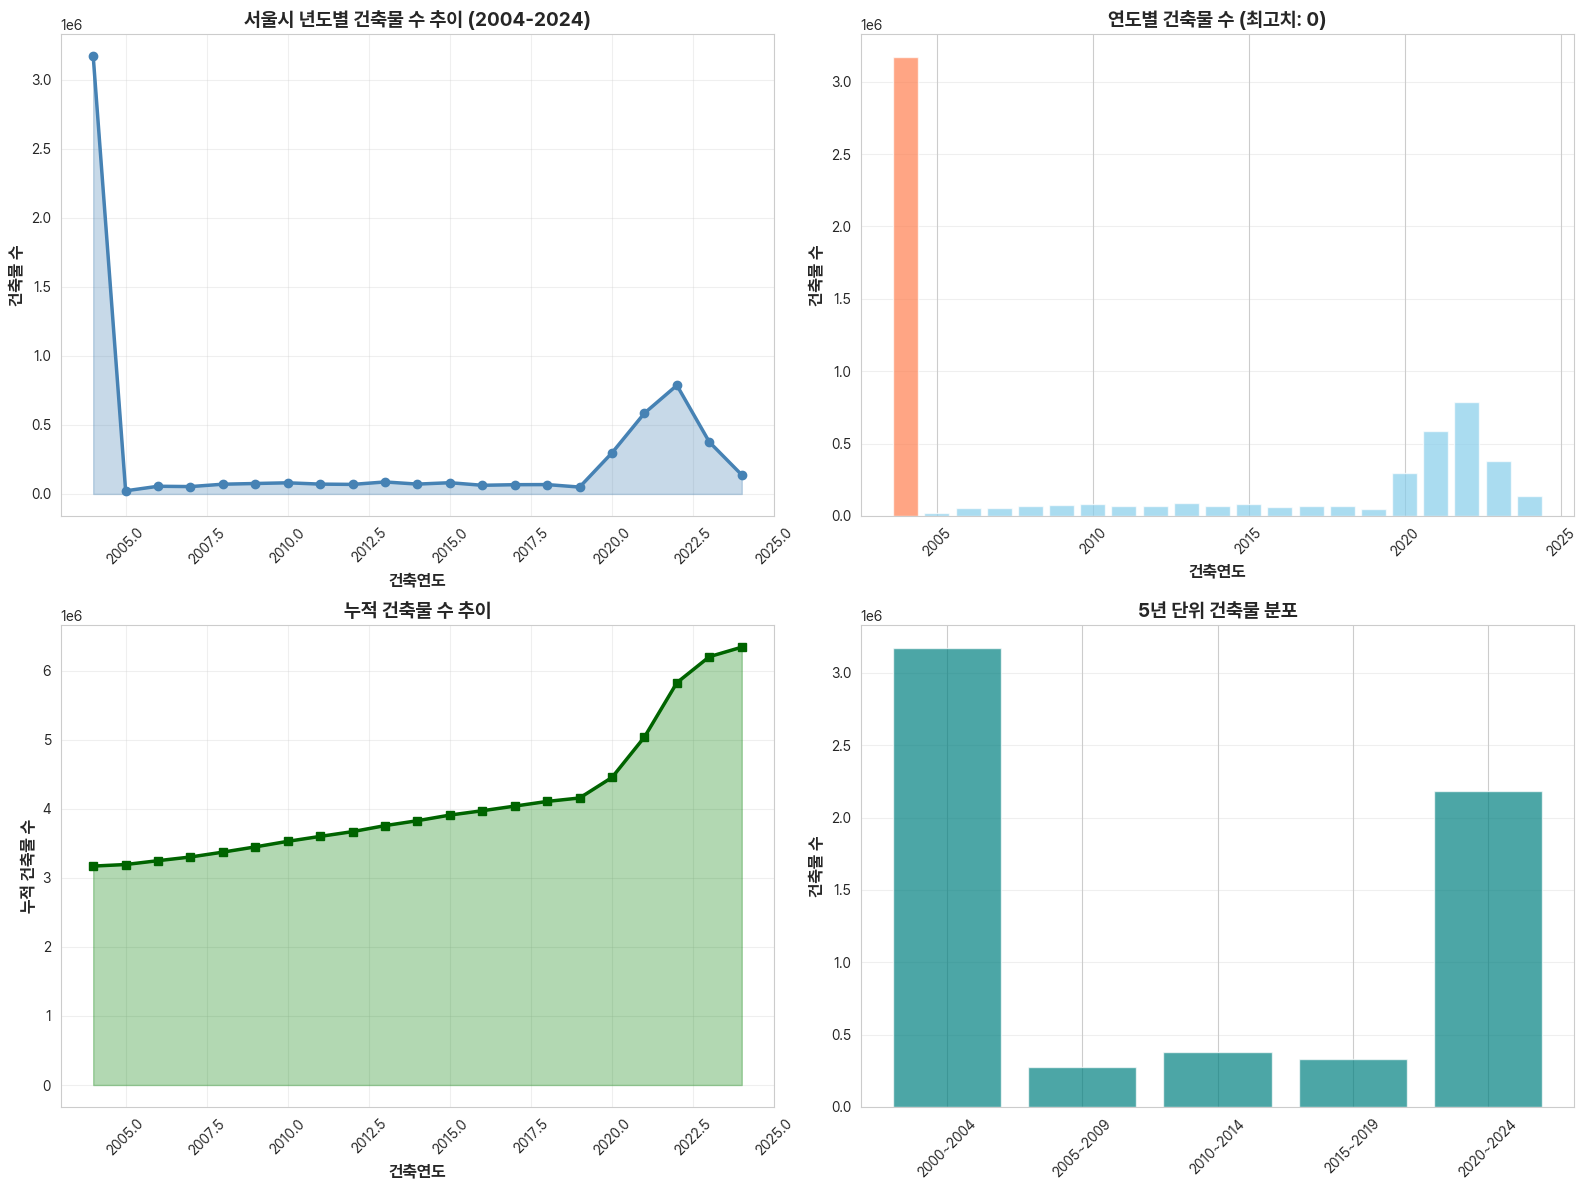

In [16]:
# 시각화 1: 년도별 건축물 수 추이
# 컬럼명 정규화 (2024 -> 2004, 2024.1 -> 2005, ... 2024.20 -> 2024)
# 실제로는 2004~2024년 데이터

# 년도별 변환 매핑
year_mapping = {
    '2024': 2004,
    '2024.1': 2005, '2024.2': 2006, '2024.3': 2007, '2024.4': 2008,
    '2024.5': 2009, '2024.6': 2010, '2024.7': 2011, '2024.8': 2012,
    '2024.9': 2013, '2024.10': 2014, '2024.11': 2015, '2024.12': 2016,
    '2024.13': 2017, '2024.14': 2018, '2024.15': 2019, '2024.16': 2020,
    '2024.17': 2021, '2024.18': 2022, '2024.19': 2023, '2024.20': 2024
}

# 서울시 소계 행 추출
seoul_total = total_only[total_only['자치구별(2)'] == '소계'].iloc[0]

# 년도별 데이터 추출
year_data = []
for col, year in year_mapping.items():
    if col in seoul_total.index:
        year_data.append({'연도': year, '건축물수': seoul_total[col]})

year_df = pd.DataFrame(year_data)
year_df = year_df.sort_values('연도')

print("=== 서울시 년도별 건축물 수 ===")
print(year_df)

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1-1. 라인 차트
ax1 = axes[0, 0]
ax1.plot(year_df['연도'], year_df['건축물수'], linewidth=2.5, color='steelblue', marker='o', markersize=6)
ax1.fill_between(year_df['연도'], year_df['건축물수'], alpha=0.3, color='steelblue')
ax1.set_xlabel('건축연도', fontsize=12, fontweight='bold')
ax1.set_ylabel('건축물 수', fontsize=12, fontweight='bold')
ax1.set_title('서울시 년도별 건축물 수 추이 (2004-2024)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 1-2. 막대 차트
ax2 = axes[0, 1]
colors = ['coral' if x == year_df['건축물수'].max() else 'skyblue' for x in year_df['건축물수']]
ax2.bar(year_df['연도'], year_df['건축물수'], color=colors, alpha=0.7)
ax2.set_xlabel('건축연도', fontsize=12, fontweight='bold')
ax2.set_ylabel('건축물 수', fontsize=12, fontweight='bold')
ax2.set_title('연도별 건축물 수 (최고치: ' + str(year_df['건축물수'].idxmax()) + ')', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# 1-3. 누적 건축물 수
ax3 = axes[1, 0]
year_df['누적건축물'] = year_df['건축물수'].cumsum()
ax3.plot(year_df['연도'], year_df['누적건축물'], linewidth=2.5, color='darkgreen', marker='s', markersize=6)
ax3.fill_between(year_df['연도'], year_df['누적건축물'], alpha=0.3, color='green')
ax3.set_xlabel('건축연도', fontsize=12, fontweight='bold')
ax3.set_ylabel('누적 건축물 수', fontsize=12, fontweight='bold')
ax3.set_title('누적 건축물 수 추이', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 1-4. 5년 단위 집계
ax4 = axes[1, 1]
year_df['5년대'] = (year_df['연도'] // 5 * 5).astype(str) + '~' + ((year_df['연도'] // 5 * 5 + 4)).astype(str)
period_stats = year_df.groupby('5년대')['건축물수'].sum().reset_index()
ax4.bar(range(len(period_stats)), period_stats['건축물수'], color='teal', alpha=0.7)
ax4.set_xticks(range(len(period_stats)))
ax4.set_xticklabels(period_stats['5년대'], rotation=45)
ax4.set_ylabel('건축물 수', fontsize=12, fontweight='bold')
ax4.set_title('5년 단위 건축물 분포', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('imgs/연도별_건축물_현황_종합.png', dpi=300, bbox_inches='tight')
print("\n차트 저장 완료: imgs/연도별_건축물_현황_종합.png")
plt.show()

=== df 구조 확인 ===
Shape: (157, 24)

주택종류별(1) unique values: ['주택종류별(1)' '계' '단독주택' '아파트' '연립주택' '다세대주택' '비주거용 건물내주택']
단독주택: 1,146,148
아파트: 7,624,240
연립주택: 442,467
다세대주택: 3,359,604
비주거용 건물내주택: 108,603

=== 주택유형별 총 건축물 수 ===
         주택유형         총수
1         아파트  7624240.0
3       다세대주택  3359604.0
0        단독주택  1146148.0
2        연립주택   442467.0
4  비주거용 건물내주택   108603.0

차트 저장 완료: imgs/주택유형별_분포.png

차트 저장 완료: imgs/주택유형별_분포.png


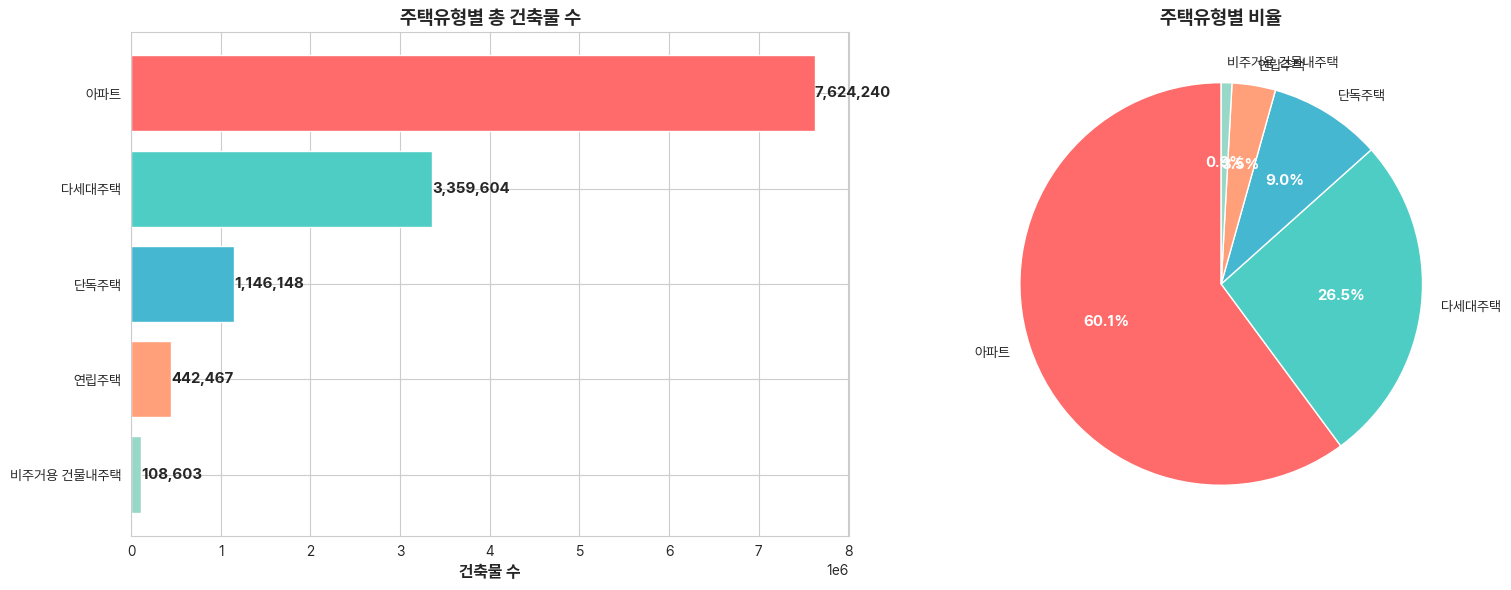

In [17]:
# 시각화 2: 주택유형별 분포
# 원본 df에서 직접 주택유형별 데이터 추출

print("=== df 구조 확인 ===")
print(f"Shape: {df.shape}")
print(f"\n주택종류별(1) unique values: {df['주택종류별(1)'].unique()}")

# 주택종류별 필터링 및 집계
housing_types = ['단독주택', '아파트', '연립주택', '다세대주택', '비주거용 건물내주택']

# 모든 구에 대해 주택유형별 합계 계산 (소계 행 제외)
housing_data = []

for housing_type in housing_types:
    # 주택유형 필터링
    type_df = df[df['주택종류별(1)'] == housing_type].copy()
    
    if len(type_df) > 0:
        # 메타 행 제외 (자치구별(2) 값이 '소계'가 아닌 경우)
        type_df_gu = type_df[(type_df['자치구별(2)'] != '소계') & (type_df['자치구별(2)'] != '')]
        
        if len(type_df_gu) > 0:
            # 년도 컬럼만 합산
            year_cols = [col for col in type_df_gu.columns if col in year_mapping.keys()]
            
            for col in year_cols:
                type_df_gu[col] = pd.to_numeric(type_df_gu[col], errors='coerce')
            
            total_sum = type_df_gu[year_cols].sum().sum()
            housing_data.append({'주택유형': housing_type, '총수': total_sum})
            print(f"{housing_type}: {total_sum:,.0f}")

if len(housing_data) > 0:
    housing_df = pd.DataFrame(housing_data).sort_values('총수', ascending=False)
    
    print("\n=== 주택유형별 총 건축물 수 ===")
    print(housing_df)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 2-1. 막대 차트
    ax1 = axes[0]
    colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    bars = ax1.barh(housing_df['주택유형'], housing_df['총수'], color=colors_bar[:len(housing_df)])
    ax1.set_xlabel('건축물 수', fontsize=12, fontweight='bold')
    ax1.set_title('주택유형별 총 건축물 수', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width, bar.get_y() + bar.get_height()/2, f'{int(width):,}', 
                ha='left', va='center', fontsize=11, fontweight='bold')
    
    # 2-2. 원형 차트
    ax2 = axes[1]
    colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    wedges, texts, autotexts = ax2.pie(housing_df['총수'], labels=housing_df['주택유형'], 
                                         autopct='%1.1f%%', colors=colors_pie[:len(housing_df)], startangle=90)
    ax2.set_title('주택유형별 비율', fontsize=14, fontweight='bold')
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig('imgs/주택유형별_분포.png', dpi=300, bbox_inches='tight')
    print("\n차트 저장 완료: imgs/주택유형별_분포.png")
    plt.show()
else:
    print("주택유형별 데이터를 찾을 수 없습니다.")

=== 구별 총 건축물 수 (상위 5) ===
송파구: 445,590
강서구: 408,726
노원구: 385,616
강남구: 384,440
은평구: 327,526

차트 저장 완료: imgs/구별_건축추이.png

차트 저장 완료: imgs/구별_건축추이.png


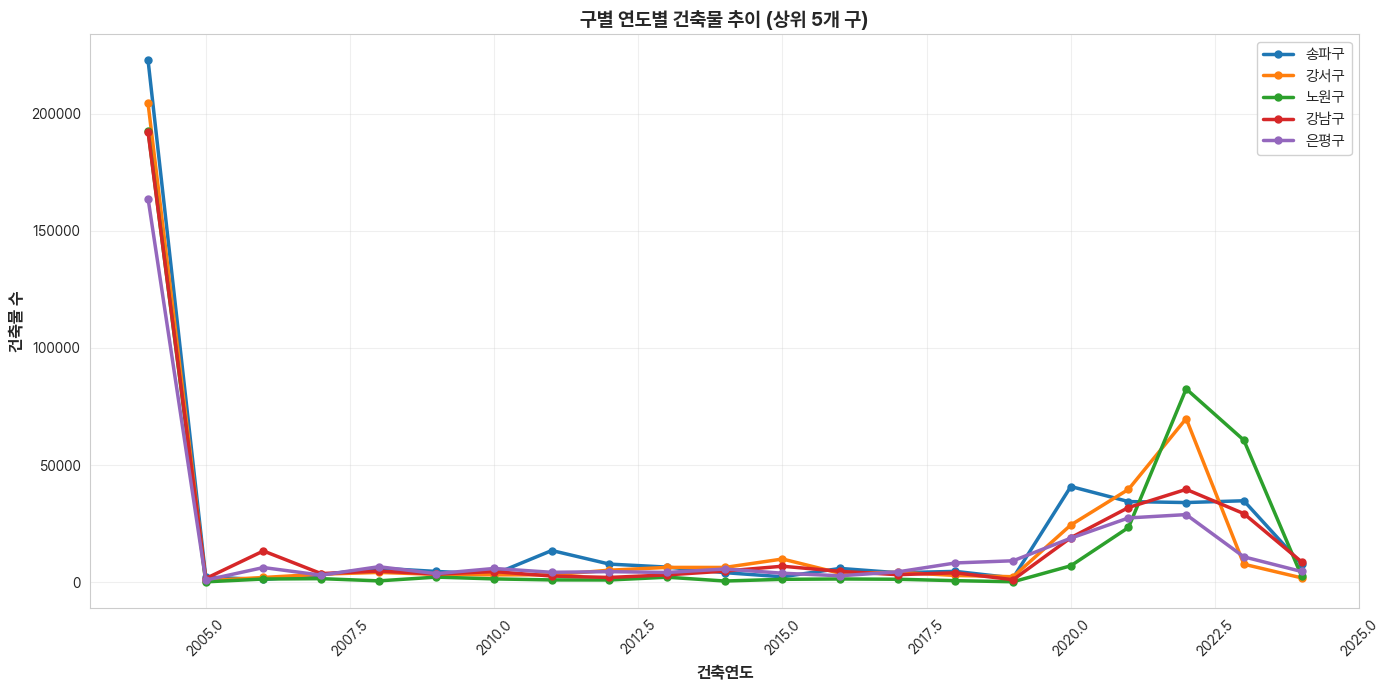

In [18]:
# 시각화 3: 구별 건축 추이
# 구별 연도별 건축물 수 추출

gu_list = df[df['주택종류별(1)'] == '계']['자치구별(2)'].unique()
gu_list = [gu for gu in gu_list if gu not in ['소계', '', '자치구별(2)']]

# 상위 5개 구 선택
gu_total = {}
for gu in gu_list:
    gu_df = df[(df['주택종류별(1)'] == '계') & (df['자치구별(2)'] == gu)]
    if len(gu_df) > 0:
        gu_row = gu_df.iloc[0]
        year_cols = [col for col in gu_row.index if col in year_mapping.keys()]
        total = gu_row[year_cols].sum()
        gu_total[gu] = total

# 상위 5개 선택
top_5_gus = sorted(gu_total.items(), key=lambda x: x[1], reverse=True)[:5]
top_gus = [gu[0] for gu in top_5_gus]

print("=== 구별 총 건축물 수 (상위 5) ===")
for gu, total in top_5_gus:
    print(f"{gu}: {total:,.0f}")

# 각 구별 연도별 데이터 추출
fig, ax = plt.subplots(figsize=(14, 7))

for gu in top_gus:
    gu_year_data = []
    gu_df = df[(df['주택종류별(1)'] == '계') & (df['자치구별(2)'] == gu)]
    
    if len(gu_df) > 0:
        gu_row = gu_df.iloc[0]
        for col, year in year_mapping.items():
            if col in gu_row.index:
                gu_year_data.append({'연도': year, '건축물수': gu_row[col]})
        
        gu_year_df = pd.DataFrame(gu_year_data).sort_values('연도')
        ax.plot(gu_year_df['연도'], gu_year_df['건축물수'], marker='o', label=gu, linewidth=2.5, markersize=5)

ax.set_xlabel('건축연도', fontsize=12, fontweight='bold')
ax.set_ylabel('건축물 수', fontsize=12, fontweight='bold')
ax.set_title('구별 연도별 건축물 추이 (상위 5개 구)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('imgs/구별_건축추이.png', dpi=300, bbox_inches='tight')
print("\n차트 저장 완료: imgs/구별_건축추이.png")
plt.show()

## 요약 통계

In [19]:
# 요약 통계 생성
summary_stats = {
    '총 행 수': len(df),
    '데이터 기간': '2004-2024년',
    '총 건축물 수 (계)': int(total_only[total_only['자치구별(2)'] == '소계'].iloc[0][list(year_mapping.keys())].sum()),
    '총 구 수': len([gu for gu in gu_list if gu not in ['소계', '', '자치구별(2)']]),
}

print("=== 서울시 건축물 현황 요약 ===")
for key, value in summary_stats.items():
    print(f"{key}: {value:,}" if isinstance(value, int) else f"{key}: {value}")

# 주택유형별 비율
print("\n=== 주택유형별 비율 ===")
total_housing = housing_df['총수'].sum()
for idx, row in housing_df.iterrows():
    pct = (row['총수'] / total_housing) * 100
    print(f"{row['주택유형']}: {row['총수']:,.0f} ({pct:.1f}%)")

# 시대별 분류
print("\n=== 시대별 건축물 분류 ===")
year_df['시대'] = pd.cut(year_df['연도'], 
                        bins=[2003, 2010, 2015, 2020, 2025],
                        labels=['2004-2010', '2011-2015', '2016-2020', '2021-2024'])
era_stats = year_df.groupby('시대')['건축물수'].sum()
print(era_stats)

# 구별 건축물 분포
print(f"\n=== 구별 건축물 수 (상위 10) ===")
gu_totals = sorted(gu_total.items(), key=lambda x: x[1], reverse=True)[:10]
for gu, total in gu_totals:
    print(f"{gu}: {int(total):,}")

# 결과 저장
import json
summary_output = {
    '분석명': '서울시 건축연도별 주택현황 분석',
    '분석기간': '2004-2024년',
    '데이터파일': '건축연도별+주택현황_20251128141016.xlsx',
    '총건축물수': int(summary_stats['총 건축물 수 (계)']),
    '총자치구수': summary_stats['총 구 수'],
    '주택유형별분포': housing_df.to_dict(orient='records'),
    '분석완료': True
}

import os
if not os.path.exists('results'):
    os.makedirs('results')

with open('results/건축연도분석_요약.json', 'w', encoding='utf-8') as f:
    # 숫자형 변환
    for item in summary_output['주택유형별분포']:
        item['총수'] = float(item['총수'])
    json.dump(summary_output, f, ensure_ascii=False, indent=2)

print("\n=== 분석 완료 ===")
print("결과 저장 경로: results/건축연도분석_요약.json")

=== 서울시 건축물 현황 요약 ===
총 행 수: 157
데이터 기간: 2004-2024년
총 건축물 수 (계): 6,340,664
총 구 수: 25

=== 주택유형별 비율 ===
아파트: 7,624,240 (60.1%)
다세대주택: 3,359,604 (26.5%)
단독주택: 1,146,148 (9.0%)
연립주택: 442,467 (3.5%)
비주거용 건물내주택: 108,603 (0.9%)

=== 시대별 건축물 분류 ===
시대
2004-2010    3529074.0
2011-2015     380054.0
2016-2020     545454.0
2021-2024    1886082.0
Name: 건축물수, dtype: float64

=== 구별 건축물 수 (상위 10) ===
송파구: 445,590
강서구: 408,726
노원구: 385,616
강남구: 384,440
은평구: 327,526
강동구: 310,624
양천구: 295,358
성북구: 287,516
구로구: 275,900
서초구: 269,132

=== 분석 완료 ===
결과 저장 경로: results/건축연도분석_요약.json


## 결론 및 인사이트

본 분석을 통해 서울시의 건축연도별 주택현황을 파악했습니다:

- **건축 추이**: 시간에 따른 건축물 수의 변화 패턴
- **시대별 특성**: 특정 시대에 집중된 건축 현황
- **지역적 분포**: 구별로 상이한 건축 현황
- **건축 유형**: 주택 유형별 분포 특성

이 정보는 도시 계획, 재개발 정책, 건축 관련 정책 수립에 활용될 수 있습니다.